# LSTM on real DNA sequences - Filippo architecture

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import subprocess
import numpy as np
from Bio import SeqIO

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, RMSprop
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, LSTM, SimpleRNN, GRU

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
intr_file = '../data/hg19_intr_clean.fa'
depl_file = '../data/hg19_depl_clean.fa'

e = 0
intr_seqs = []
depl_seqs = []
for intr, depl in zip(SeqIO.parse(intr_file, 'fasta'), SeqIO.parse(depl_file, 'fasta')):
    
    #cutoff = 200
    #my_intr_seq = str(intr.seq)[0:cutoff]
    #my_depl_seq = str(depl.seq)[0:cutoff]
    #intr_seqs.append(my_intr_seq)
    #depl_seqs.append(my_depl_seq)
    
    step = 200; jump = 1; a = 0; b = step; n_jumps = 5
    for j in range(n_jumps):
        s_intr = str(intr.seq)[a:b]
        s_depl = str(depl.seq)[a:b]
        intr_seqs.append(s_intr)
        depl_seqs.append(s_depl)
        a = a + jump
        b = a + step
    
    e = e + 1
    if e%20000 == 0:
        print('Finished ' + str(e) + ' entries')
        
def getKmers(sequence, size):
    return [sequence[x:x+size].upper() for x in range(len(sequence) - size + 1)]

kmer = 5
intr_texts = [' '.join(getKmers(i, kmer)) for i in intr_seqs]
depl_texts = [' '.join(getKmers(i, kmer)) for i in depl_seqs]

Finished 20000 entries
Finished 40000 entries
Finished 60000 entries


In [4]:
merge_texts = intr_texts + depl_texts
len(merge_texts)

733640

In [5]:
labels = list(np.ones(len(intr_texts))) + list(np.zeros(len(depl_texts)))
print(len(labels))

733640


In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(merge_texts)

encoded_docs = tokenizer.texts_to_sequences(merge_texts)
max_length = max([len(s.split()) for s in merge_texts])
X = pad_sequences(encoded_docs, maxlen = max_length, padding = 'post')

print(X)
print('\n')
print(X.shape)

[[567 737 576 ... 986 853 800]
 [737 576 490 ... 853 800 496]
 [576 490 638 ... 800 496 151]
 ...
 [ 42  40   5 ... 166 153   3]
 [ 40   5   3 ... 153   3  18]
 [  5   3   1 ...   3  18  39]]


(733640, 196)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = 0.20, random_state = 42)

In [8]:
print(X_train.shape)
print(X_test.shape)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

(586912, 196)
(146728, 196)


In [9]:
max_length = max([len(s.split()) for s in merge_texts])
print(max_length)

196


In [10]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

1025


In [11]:
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, LSTM, SimpleRNN, GRU, Bidirectional, SpatialDropout1D
from tensorflow.keras import regularizers

model = Sequential()
model.add(Embedding(vocab_size, 4, input_length = max_length))
model.add(SpatialDropout1D(0.4))

model.add(Bidirectional(LSTM(10, 
                             #dropout = 0.2, recurrent_dropout = 0.2,
                             kernel_regularizer=None,
                             recurrent_regularizer=regularizers.l2(0.1), 
                             bias_regularizer=None, 
                             activity_regularizer=None)))

model.add(Dense(1, activation = 'sigmoid'))

epochs = 5
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor = 'val_acc', verbose = 1, 
                             save_best_only = True, mode = 'max')
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 196, 4)            4100      
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 196, 4)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 20)                1200      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 5,321
Trainable params: 5,321
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
history = model.fit(X_train, y_train, 
                    epochs = epochs, verbose = 1, validation_split = 0.2, batch_size = 32, shuffle = True, 
                    callbacks = [checkpoint])

Train on 469529 samples, validate on 117383 samples
Epoch 1/5
469529/469529 [==============================] - 514s 1ms/sample - loss: 0.6931 - accuracy: 0.5463 - val_loss: 0.6717 - val_accuracy: 0.5625
Epoch 2/5
469529/469529 [==============================] - 503s 1ms/sample - loss: 0.6731 - accuracy: 0.5596 - val_loss: 0.6682 - val_accuracy: 0.5683
Epoch 3/5
469529/469529 [==============================] - 504s 1ms/sample - loss: 0.6719 - accuracy: 0.5622 - val_loss: 0.6673 - val_accuracy: 0.5722
Epoch 4/5
469529/469529 [==============================] - 521s 1ms/sample - loss: 0.6710 - accuracy: 0.5651 - val_loss: 0.6659 - val_accuracy: 0.5767
Epoch 5/5
469529/469529 [==============================] - 500s 1ms/sample - loss: 0.6709 - accuracy: 0.5653 - val_loss: 0.6721 - val_accuracy: 0.5707


Confusion matrix:
 [[19038 54320]
 [ 9031 64339]]


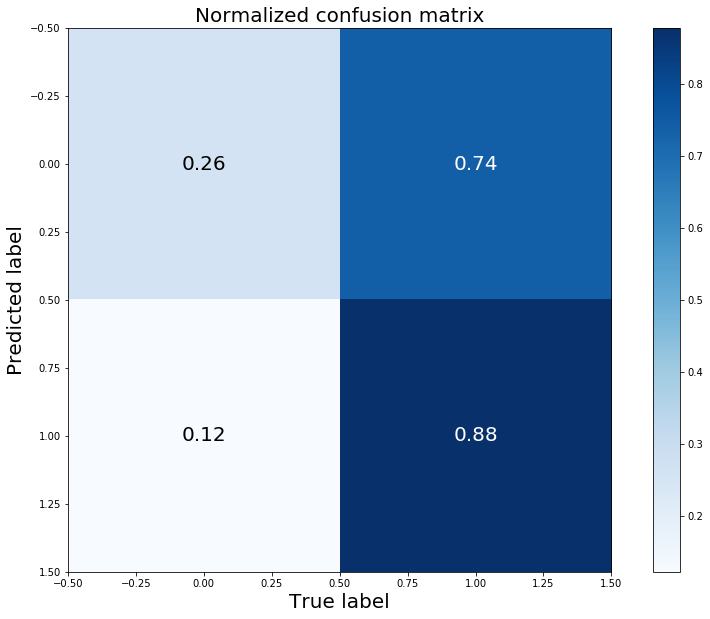

In [13]:
plt.figure(figsize = (15,10))

predicted_labels = model.predict(X_test)
cm = confusion_matrix(y_test, [np.round(i[0]) for i in predicted_labels])
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap = plt.cm.Blues)
plt.title('Normalized confusion matrix', fontsize = 20)
plt.colorbar()
plt.xlabel('True label', fontsize = 20)
plt.ylabel('Predicted label', fontsize = 20)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment = 'center', verticalalignment = 'center', fontsize = 20,
             color='white' if cm[i, j] > 0.5 else 'black')
plt.show()

In [14]:
scores = model.evaluate(X_test, y_test, verbose = 0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 56.82%
